In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy 
import pickle

import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.cosmology import FlatLambdaCDM

from scipy import interpolate
from sklearn.neighbors import KDTree
from astropy.table import Table, Column, vstack, join

color_bins = ["#377eb8", "#e41a1c", "#1b9e77", "#984ea3"]
marker_bins = ['o', 's', 'H', 'D', '+']
msize_bins = [160, 140, 200, 180, 150]

In [2]:
import jianbing

from jianbing import hsc
from jianbing import utils
from jianbing import visual
from jianbing import catalog
from jianbing import wlensing

In [3]:
data_dir = jianbing.DATA_DIR

fig_dir = jianbing.FIG_DIR

sim_dir = jianbing.SIM_DIR
bin_dir = jianbing.BIN_DIR
res_dir = jianbing.RES_DIR

### DSigma profiles of mock galaxies

In [4]:
sim_dsig_all = Table.read(os.path.join(sim_dir, 'sim_merge_all_dsig.fits'))
sim_dsig_cen = Table.read(os.path.join(sim_dir, 'sim_mdpl2_cen_dsig.fits'))

### Compare the $\Delta\Sigma$ profiles of (possible) massive satellite galaxies to their central counterparts

#### Pre-compute lensing results for HSC galaxies

In [5]:
# Pre-compute
s16a_precompute = os.path.join(data_dir, 'topn_public_s16a_medium_precompute.hdf5')

hsc_pre = Table.read(s16a_precompute, path='hsc')

cols_use = ['object_id', 'z', 'field', 'w_sys', 'sum 1', 'sum w_ls', 'sum w_ls e_t',
            'sum w_ls e_t sigma_crit', 'sum w_ls e_t sigma_crit f_bias', 'sum (w_ls e_t sigma_crit)^2', 
            'sum w_ls z_l', 'sum w_ls z_s', 'sum w_ls m', 'sum w_ls (1 - e_rms^2)', 'sum w_ls A p(R_2=0.3)', 'n_s_tot']

In [6]:
hsc_massive = Table.read(os.path.join(data_dir, 's16a_massive_logm_11.2.fits'))

hsc_pre = join(hsc_massive, hsc_pre[cols_use], keys='object_id', join_type='inner', metadata_conflicts='silent')

mask = (
    (hsc_pre['logm_10_100'] >= 9.5) & (hsc_pre['logm_max'] >= 11.2) & 
    (hsc_pre['logm_50_100'] >= 9.5) & (hsc_pre['bsm_s18a'])
)

hsc_use = hsc_pre[mask]

#### Pre-compute lensing results for randoms

In [7]:
# Lensing data using medium photo-z quality cut
s16a_lensing = os.path.join(data_dir, 's16a_weak_lensing_medium.hdf5')

# Random
s16a_rand = Table.read(s16a_lensing, path='random')

#### Pre-defined number density bins

In [8]:
topn_bins = Table.read(os.path.join(bin_dir, 'topn_bins.fits'))

### Get the DSigma profiles for different choices of cylinder 

#### `cen_mask_1`: 1 Mpc radius; 20 Mpc in length

In [27]:
cen = hsc_use[hsc_use['cen_mask_1'] & np.isfinite(hsc_use['logm_50_100']) & 
              np.isfinite(hsc_use['logm_100'])]
sat = hsc_use[~hsc_use['cen_mask_1'] & np.isfinite(hsc_use['logm_50_100']) & 
              np.isfinite(hsc_use['logm_100'])]

mask_cen = ((cen['logm_100'] >= 11.6) & (cen['logm_100'] <= 11.8))
mask_sat = ((sat['logm_100'] >= 11.6) & (sat['logm_100'] <= 11.8))

print("# There are {:d} central galaxies in the mass bin".format(mask_cen.sum()))
print("# There are {:d} satellite candidates in the mass bin".format(mask_sat.sum()))

cen_use = cen[mask_cen]
sat_use = sat[mask_sat]

y = np.stack([np.asarray(sat_use['logm_50']), np.asarray(sat_use['logm_50_100'])]).T
X = np.stack([np.asarray(cen_use['logm_50']), np.asarray(cen_use['logm_50_100'])]).T
kdt = KDTree(X, leaf_size=10, metric='euclidean')
idx = kdt.query(y, k=7, return_distance=False)
cen_match = cen_use[(np.unique(idx.flatten()))]

print("# Match the satellite to {:d} centrals in M50 - M[50,100] plane".format(len(cen_match)))

cen_all_1 = wlensing.batch_dsigma_profiles(
    cen_use, s16a_rand, [(cen_use['z'] > 0)], n_rand=100000, n_boot=100,
    n_jk=45, verbose=True, n_jobs=None)

cen_mat_1 = wlensing.batch_dsigma_profiles(
    cen_match, s16a_rand, [(cen_match['z'] > 0)], n_rand=100000, n_boot=100,
    n_jk=45, verbose=True, n_jobs=None)

sat_1 = wlensing.batch_dsigma_profiles(
    sat_use, s16a_rand, [(sat_use['z'] > 0)], n_rand=100000, n_boot=100,
    n_jk=45, verbose=True, n_jobs=None)

# There are 1827 central galaxies in the mass bin
# There are 138 satellite candidates in the mass bin
# Match the satellite to 677 centrals in M50 - M[50,100] plane
There are 1827 objects in sample 1
There are 677 objects in sample 1
There are 138 objects in sample 1


#### `cen_mask_2`: 1.5 Mpc radius; 30 Mpc in length

In [28]:
cen = hsc_use[hsc_use['cen_mask_2'] & np.isfinite(hsc_use['logm_50_100']) & 
              np.isfinite(hsc_use['logm_100'])]
sat = hsc_use[~hsc_use['cen_mask_2'] & np.isfinite(hsc_use['logm_50_100']) & 
              np.isfinite(hsc_use['logm_100'])]

mask_cen = ((cen['logm_100'] >= 11.6) & (cen['logm_100'] <= 11.8))
mask_sat = ((sat['logm_100'] >= 11.6) & (sat['logm_100'] <= 11.8))

print("# There are {:d} central galaxies in the mass bin".format(mask_cen.sum()))
print("# There are {:d} satellite candidates in the mass bin".format(mask_sat.sum()))

cen_use = cen[mask_cen]
sat_use = sat[mask_sat]

y = np.stack([np.asarray(sat_use['logm_50']), np.asarray(sat_use['logm_50_100'])]).T
X = np.stack([np.asarray(cen_use['logm_50']), np.asarray(cen_use['logm_50_100'])]).T
kdt = KDTree(X, leaf_size=10, metric='euclidean')
idx = kdt.query(y, k=7, return_distance=False)
cen_match = cen_use[(np.unique(idx.flatten()))]

print("# Match the satellite to {:d} centrals in M50 - M[50,100] plane".format(len(cen_match)))

cen_all_2 = wlensing.batch_dsigma_profiles(
    cen_use, s16a_rand, [(cen_use['z'] > 0)], n_rand=100000, n_boot=100,
    n_jk=45, verbose=True, n_jobs=None)

cen_mat_2 = wlensing.batch_dsigma_profiles(
    cen_match, s16a_rand, [(cen_match['z'] > 0)], n_rand=100000, n_boot=100,
    n_jk=45, verbose=True, n_jobs=None)

sat_2 = wlensing.batch_dsigma_profiles(
    sat_use, s16a_rand, [(sat_use['z'] > 0)], n_rand=100000, n_boot=100,
    n_jk=45, verbose=True, n_jobs=None)

# There are 1726 central galaxies in the mass bin
# There are 239 satellite candidates in the mass bin
# Match the satellite to 992 centrals in M50 - M[50,100] plane
There are 1726 objects in sample 1
There are 992 objects in sample 1
There are 239 objects in sample 1


#### `cen_mask_3`: 1 Mpc radius; 40 Mpc in length

In [29]:
cen = hsc_use[hsc_use['cen_mask_3'] & np.isfinite(hsc_use['logm_50_100']) & 
              np.isfinite(hsc_use['logm_100'])]
sat = hsc_use[~hsc_use['cen_mask_3'] & np.isfinite(hsc_use['logm_50_100']) & 
              np.isfinite(hsc_use['logm_100'])]

mask_cen = ((cen['logm_100'] >= 11.6) & (cen['logm_100'] <= 11.8))
mask_sat = ((sat['logm_100'] >= 11.6) & (sat['logm_100'] <= 11.8))

print("# There are {:d} central galaxies in the mass bin".format(mask_cen.sum()))
print("# There are {:d} satellite candidates in the mass bin".format(mask_sat.sum()))

cen_use = cen[mask_cen]
sat_use = sat[mask_sat]

y = np.stack([np.asarray(sat_use['logm_50']), np.asarray(sat_use['logm_50_100'])]).T
X = np.stack([np.asarray(cen_use['logm_50']), np.asarray(cen_use['logm_50_100'])]).T
kdt = KDTree(X, leaf_size=10, metric='euclidean')
idx = kdt.query(y, k=7, return_distance=False)
cen_match = cen_use[(np.unique(idx.flatten()))]

print("# Match the satellite to {:d} centrals in M50 - M[50,100] plane".format(len(cen_match)))

cen_all_3 = wlensing.batch_dsigma_profiles(
    cen_use, s16a_rand, [(cen_use['z'] > 0)], n_rand=100000, n_boot=100,
    n_jk=45, verbose=True, n_jobs=None)

cen_mat_3 = wlensing.batch_dsigma_profiles(
    cen_match, s16a_rand, [(cen_match['z'] > 0)], n_rand=100000, n_boot=100,
    n_jk=45, verbose=True, n_jobs=None)

sat_3 = wlensing.batch_dsigma_profiles(
    sat_use, s16a_rand, [(sat_use['z'] > 0)], n_rand=100000, n_boot=100,
    n_jk=45, verbose=True, n_jobs=None)

# There are 1804 central galaxies in the mass bin
# There are 161 satellite candidates in the mass bin
# Match the satellite to 765 centrals in M50 - M[50,100] plane
There are 1804 objects in sample 1
There are 765 objects in sample 1
There are 161 objects in sample 1


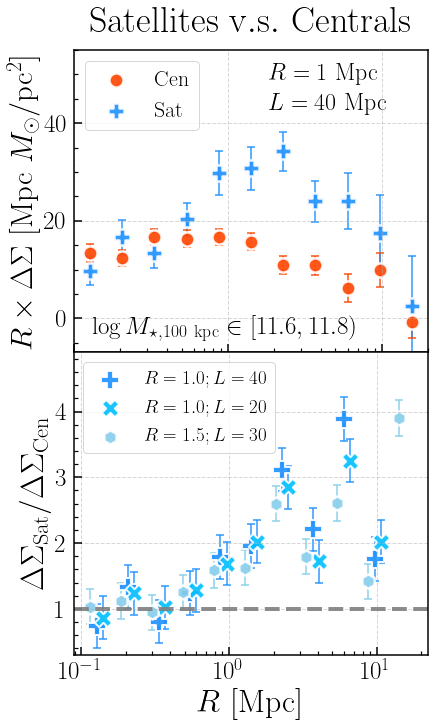

In [53]:
fig = plt.figure(figsize=(6, 10))
fig.subplots_adjust(
    left=0.175, bottom=0.09, right=0.995, top=0.93, wspace=0, hspace=0)

ax1 = fig.add_subplot(2, 1, 1)
ax1.set_xscale("log", nonpositive='clip')
#ax1.set_yscale("log", nonpositive='clip')

ax1.errorbar(
    cen_mat_3.meta['r_mpc'], cen_mat_3.meta['r_mpc'] * cen_mat_3[0]['dsigma'], 
    yerr=(cen_mat_3.meta['r_mpc'] * cen_mat_3[0]['dsig_err_jk']), 
    ecolor='orangered', color='w', alpha=0.7, 
    capsize=4, capthick=2.0, elinewidth=2.0, label='__no_label__', fmt='o', zorder=0)
ax1.scatter(
    cen_mat_3.meta['r_mpc'], cen_mat_3.meta['r_mpc'] * cen_mat_3[0]['dsigma'], 
    s=200, marker='o', alpha=0.9, facecolor='orangered', edgecolor='w', 
    linewidth=2.5, label=r'$\rm Cen$')

ax1.errorbar(
    sat_3.meta['r_mpc'], sat_3.meta['r_mpc'] * sat_3[0]['dsigma'], 
    yerr=(sat_3.meta['r_mpc'] * sat_3[0]['dsig_err_jk']), 
    ecolor='dodgerblue', color='w', alpha=0.7, 
    capsize=4, capthick=2.0, elinewidth=2.0, label='__no_label__', fmt='o', zorder=0)
ax1.scatter(
    sat_3.meta['r_mpc'], sat_3.meta['r_mpc'] * sat_3[0]['dsigma'], s=270, marker='P', 
    alpha=0.9, facecolor='dodgerblue', edgecolor='w', 
    linewidth=2.5, label=r'$\rm Sat$')

ax1.legend(loc='upper left', fontsize=22)
ax1.set_xticklabels([])
ax1.set_ylim(-7, 55)


ax2 = fig.add_subplot(2, 1, 2)
ax2.set_xscale("log", nonpositive='clip')

ax2.axhline(1.0, linewidth=4.0, linestyle='--', c='grey', alpha=0.9)

err_ratio = np.asarray(
    np.sqrt((cen_mat_3[0]['dsig_err_jk'] / cen_mat_3[0]['dsigma']) ** 2 + 
            (sat_3[0]['dsig_err_jk'] / sat_3[0]['dsigma']) ** 2))[0]

ax2.errorbar(
    sat_3.meta['r_mpc'], sat_3[0]['dsigma'] / cen_mat_3[0]['dsigma'], 
    yerr=err_ratio, 
    ecolor='dodgerblue', color='w', alpha=0.7, 
    capsize=4, capthick=2.0, elinewidth=2.0, label='__no_label__', fmt='o', zorder=0)
ax2.scatter(
    sat_3.meta['r_mpc'], sat_3[0]['dsigma'] / cen_mat_3[0]['dsigma'], s=300, marker='P', 
    alpha=0.9, facecolor='dodgerblue', edgecolor='w', 
    linewidth=2.0, label=r'$R = 1.0; L=40$')

err_ratio = np.asarray(
    np.sqrt((cen_mat_1[0]['dsig_err_jk'] / cen_mat_1[0]['dsigma']) ** 2 + 
            (sat_1[0]['dsig_err_jk'] / sat_1[0]['dsigma']) ** 2))[0]

ax2.errorbar(
    sat_1.meta['r_mpc'] * 1.1, sat_1[0]['dsigma'] / cen_mat_1[0]['dsigma'], 
    yerr=err_ratio, 
    ecolor='dodgerblue', color='w', alpha=0.7, 
    capsize=4, capthick=2.0, elinewidth=2.0, label='__no_label__', fmt='o', zorder=0)
ax2.scatter(
    sat_1.meta['r_mpc'] * 1.1, sat_1[0]['dsigma'] / cen_mat_1[0]['dsigma'], s=300, marker='X', 
    alpha=0.9, facecolor='deepskyblue', edgecolor='w', 
    linewidth=2.0, label=r'$R = 1.0; L=20$')

err_ratio_2 = np.asarray(
    np.sqrt((cen_mat_2[0]['dsig_err_jk'] / cen_mat_2[0]['dsigma']) ** 2 + 
            (sat_2[0]['dsig_err_jk'] / sat_2[0]['dsigma']) ** 2))[0]

ax2.errorbar(
    sat_2.meta['r_mpc'] * 0.9, sat_2[0]['dsigma'] / cen_mat_2[0]['dsigma'], 
    yerr=err_ratio_2, 
    ecolor='skyblue', color='w', alpha=0.7, 
    capsize=4, capthick=2.0, elinewidth=2.0, label='__no_label__', fmt='o', zorder=0)
ax2.scatter(
    sat_2.meta['r_mpc'] * 0.9, sat_2[0]['dsigma'] / cen_mat_2[0]['dsigma'], s=200, marker='h', 
    alpha=0.9, facecolor='skyblue', edgecolor='w', 
    linewidth=2.5, label=r'$R=1.5; L=30$')

ax2.legend(loc='best', fontsize=19)

ax2.set_ylim(0.3, 4.9)

_ = ax2.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=32)

_ = ax1.text(0.05, 0.06, r'$\log M_{\star, 100\ \rm kpc} \in [11.6, 11.8)$', 
             fontsize=25, transform=ax1.transAxes)

_ = ax1.text(0.55, 0.90, r'$R=1\ \rm Mpc$', fontsize=24, transform=ax1.transAxes)
_ = ax1.text(0.55, 0.80, r'$L=40\ \rm Mpc$', fontsize=24, transform=ax1.transAxes)
_ = ax1.set_ylabel(r'$R \times \Delta\Sigma\ [{\rm Mpc}\ M_{\odot}/\mathrm{pc}^2]$', fontsize=31)
_ = ax2.set_ylabel(r'$\Delta\Sigma_{\rm Sat} / \Delta\Sigma_{\rm Cen}$', fontsize=32)

_ = ax1.set_title(r'$\rm Satellites\ v.s.\ Centrals$', fontsize=36, pad=18)

In [54]:
fig.savefig(os.path.join(fig_dir, 'fig_D1.png'), dpi=120)
fig.savefig(os.path.join(fig_dir, 'fig_D1.pdf'), dpi=120)